In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv(r"C:\causal inference and causal ML\smoking.csv")

In [7]:
df.head()

,Unnamed: 0,state,year,cigsale,lnincome,beer,age15to24,retprice
0,1,1,1970,89.800003,NaN,NaN,0.178862,39.599998
1,2,1,1971,95.400002,NaN,NaN,0.179928,42.700001
2,3,1,1972,101.099998,9.498476,NaN,0.180994,42.299999
3,4,1,1973,102.900002,9.550107,NaN,0.182060,42.099998
4,5,1,1974,108.199997,9.537163,NaN,0.183126,43.099998


In [9]:
df.isnull().sum()

Unnamed: 0      0
state           0
year            0
cigsale         0
lnincome      195
beer          663
age15to24     390
retprice        0
dtype: int64

In [11]:
df = df[['state', 'year', 'cigsale', 'retprice']]

In [13]:
df.head()

,state,year,cigsale,retprice
0,1,1970,89.800003,39.599998
1,1,1971,95.400002,42.700001
2,1,1972,101.099998,42.299999
3,1,1973,102.900002,42.099998
4,1,1974,108.199997,43.099998


In [15]:
df.describe()

,state,year,cigsale,retprice
count,1209.000000,1209.000000,1209.000000,1209.000000
mean,20.000000,1985.000000,118.893218,108.341936
std,11.259286,8.947973,32.767404,64.381986
min,1.000000,1970.000000,40.700001,27.299999
25%,10.000000,1977.000000,100.900002,50.000000
50%,20.000000,1985.000000,116.300003,95.500000
75%,30.000000,1993.000000,130.500000,158.399994
max,39.000000,2000.000000,296.200012,351.200012


# prepare pre-treatment data to estimate weights of controls, california state=3, treatment in 1988

In [17]:
pre_treatment_data = df[df["year"] < 1988]

cigsale_wide = pre_treatment_data.pivot(index="year", columns="state", values="cigsale")
retprice_wide = pre_treatment_data.pivot(index="year", columns="state", values="retprice")

prepared_data = pd.concat([cigsale_wide, retprice_wide], axis=0)

Y = prepared_data[3].values  # state 3 (california) as dependent variable
X = prepared_data.drop(columns=3).values  # Other states as independent variables

# to make interpretable weights, use linear and regularized linear models

# OLS

In [19]:
model = LinearRegression(fit_intercept=False).fit(X, Y)
weights = model.coef_

weights

array([-0.10326014, -0.64841664,  0.61261824,  0.0577211 ,  0.13111426,
        0.98280518,  0.06458143,  0.33249825, -0.29799389,  0.25855645,
       -0.25523342,  0.47264576, -1.07971691,  0.48333852,  0.08315339,
       -0.14907579, -0.36773136, -0.13379268, -0.58459962,  0.1874361 ,
       -0.03206248, -0.32169131, -0.14289878,  0.87390613,  0.03447818,
       -0.05139886, -0.38340105,  0.0482817 , -0.37164464,  0.16538011,
        0.39407265,  0.13021569,  0.08297472, -0.22861399, -0.59553914,
        0.97865077,  0.21853484,  0.06362497])

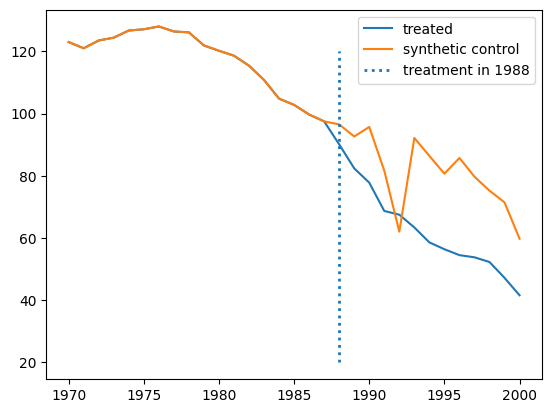

In [21]:
weighted_avg_control = (df[df.state!=3].pivot(index='year', columns='state')['cigsale'].values.dot(weights))

plt.plot(df[df.state==3]['year'], df[df.state==3]['cigsale'], label="treated")
plt.plot(df[df.state==3]['year'], weighted_avg_control, label="synthetic control")
plt.vlines(x=1988, ymin=20, ymax=120, linestyle=":", lw=2, label="treatment in 1988")
plt.ylabel("")
plt.legend()

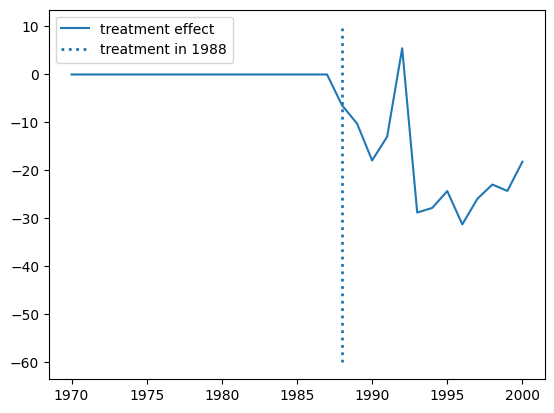

In [23]:
plt.plot(df[df.state==3]['year'], df[df.state==3]['cigsale']-weighted_avg_control, label="treatment effect")
plt.vlines(x=1988, ymin=-60, ymax=10, linestyle=":", lw=2, label="treatment in 1988")
plt.ylabel("")
plt.legend()

# LASSO

In [25]:
model = Lasso(fit_intercept=False,max_iter=12000).fit(X, Y)
weights = model.coef_

weights

array([-0.00000000e+00, -2.04656739e-01,  0.00000000e+00,  2.68774270e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -1.20713831e-04, -0.00000000e+00,  4.12801295e-02, -0.00000000e+00,
       -0.00000000e+00,  5.46166321e-02,  0.00000000e+00,  1.35352398e-01,
        4.93677671e-02,  4.33600556e-01,  4.45515433e-04,  0.00000000e+00,
        3.74209805e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  1.57682841e-01,
        0.00000000e+00,  1.95982746e-02])

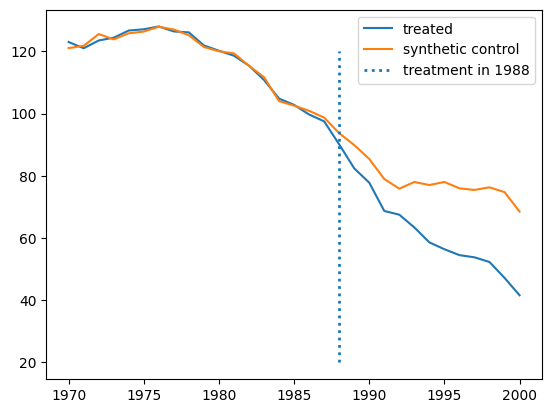

In [27]:
weighted_avg_control = (df[df.state!=3].pivot(index='year', columns='state')['cigsale'].values.dot(weights))

plt.plot(df[df.state==3]['year'], df[df.state==3]['cigsale'], label="treated")
plt.plot(df[df.state==3]['year'], weighted_avg_control, label="synthetic control")
plt.vlines(x=1988, ymin=20, ymax=120, linestyle=":", lw=2, label="treatment in 1988")
plt.ylabel("")
plt.legend()

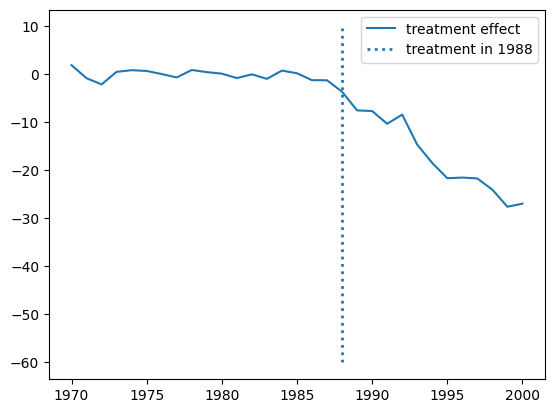

In [29]:
plt.plot(df[df.state==3]['year'], df[df.state==3]['cigsale']-weighted_avg_control, label="treatment effect")
plt.vlines(x=1988, ymin=-60, ymax=10, linestyle=":", lw=2, label="treatment in 1988")
plt.ylabel("")
plt.legend()

# Ridge

In [31]:
model = Ridge(fit_intercept=False).fit(X, Y)
weights = model.coef_

weights

array([-0.08934264, -0.66083634,  0.46340686,  0.2040867 ,  0.10197509,
        0.68019268,  0.12460298,  0.11638778, -0.22996071, -0.00752562,
       -0.20448642,  0.31164417, -0.76482031,  0.22713187,  0.05999287,
       -0.29533677, -0.25634199, -0.10234159, -0.40368023,  0.19600598,
       -0.01402795,  0.03376249, -0.23310101,  0.48476119,  0.2030442 ,
       -0.13301285, -0.35016664,  0.13439311,  0.13320259,  0.51972957,
       -0.04323645,  0.25670307, -0.0059052 , -0.04784514, -0.26372264,
        0.72012865,  0.08929118,  0.01132066])

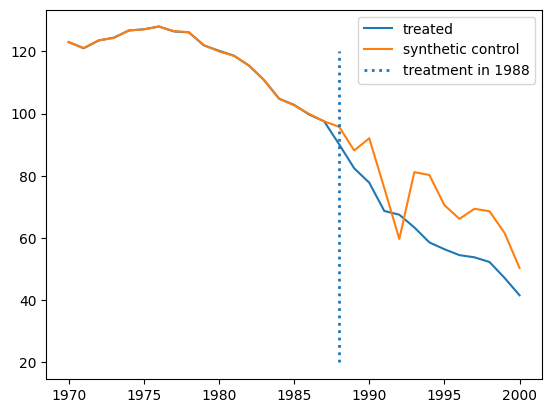

In [33]:
weighted_avg_control = (df[df.state!=3].pivot(index='year', columns='state')['cigsale'].values.dot(weights))

plt.plot(df[df.state==3]['year'], df[df.state==3]['cigsale'], label="treated")
plt.plot(df[df.state==3]['year'], weighted_avg_control, label="synthetic control")
plt.vlines(x=1988, ymin=20, ymax=120, linestyle=":", lw=2, label="treatment in 1988")
plt.ylabel("")
plt.legend()

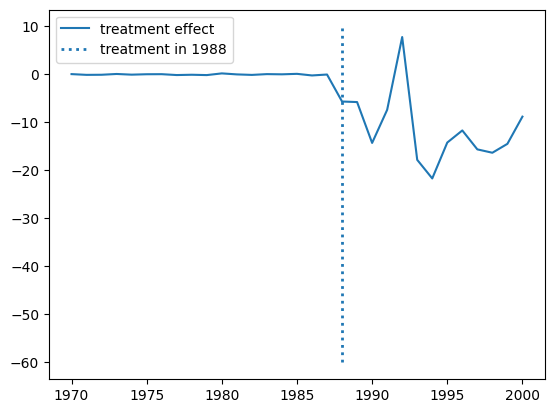

In [35]:
plt.plot(df[df.state==3]['year'], df[df.state==3]['cigsale']-weighted_avg_control, label="treatment effect")
plt.vlines(x=1988, ymin=-60, ymax=10, linestyle=":", lw=2, label="treatment in 1988")
plt.ylabel("")
plt.legend()

# ElaticNet

In [37]:
model = ElasticNet(fit_intercept=False, max_iter=12000).fit(X, Y)
weights = model.coef_

weights

array([ 0.        , -0.21131305,  0.0494276 ,  0.23783998,  0.        ,
        0.03078882,  0.01658401,  0.0875426 ,  0.05577575,  0.        ,
       -0.        ,  0.01463866, -0.12206596, -0.        ,  0.05122797,
       -0.07829027, -0.14660057,  0.07029027,  0.        ,  0.12097374,
        0.02558577,  0.34931262,  0.00642072,  0.        ,  0.11659991,
        0.        ,  0.        ,  0.        ,  0.04693072,  0.04107504,
        0.        ,  0.00545512,  0.03409916, -0.        , -0.06316077,
        0.1661982 ,  0.        ,  0.07164685])

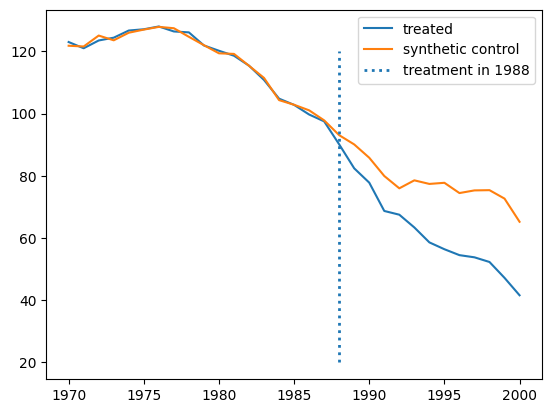

In [39]:
weighted_avg_control = (df[df.state!=3].pivot(index='year', columns='state')['cigsale'].values.dot(weights))

plt.plot(df[df.state==3]['year'], df[df.state==3]['cigsale'], label="treated")
plt.plot(df[df.state==3]['year'], weighted_avg_control, label="synthetic control")
plt.vlines(x=1988, ymin=20, ymax=120, linestyle=":", lw=2, label="treatment in 1988")
plt.ylabel("")
plt.legend()

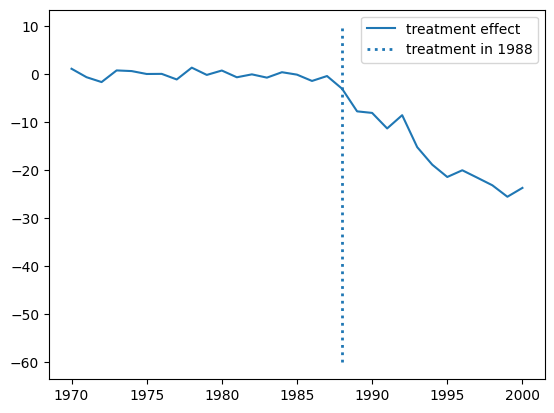

In [41]:
plt.plot(df[df.state==3]['year'], df[df.state==3]['cigsale']-weighted_avg_control, label="treatment effect")
plt.vlines(x=1988, ymin=-60, ymax=10, linestyle=":", lw=2, label="treatment in 1988")
plt.ylabel("")
plt.legend()

# placebo test, and treatment effect confidence interval

In [43]:
def synthetic_control(treat, model):
    pre_treatment_data = df[df["year"] < 1988]

    cigsale_wide = pre_treatment_data.pivot(index="year", columns="state", values="cigsale")
    retprice_wide = pre_treatment_data.pivot(index="year", columns="state", values="retprice")
    prepared_data = pd.concat([cigsale_wide, retprice_wide], axis=0)

    Y = prepared_data[treat].values 
    X = prepared_data.drop(columns=treat).values  

    weights = model.fit(X, Y).coef_
    weighted_avg_control = (df[df.state!=treat].pivot(index='year', columns='state')['cigsale'].values.dot(weights))

    treated = df[df.state == treat].sort_values('year')['cigsale'].values
    treatment_effect = treated - weighted_avg_control

    y_pred = model.predict(X)
    mse = mean_squared_error(Y, y_pred)
    
    return treatment_effect, mse

In [45]:
placebo_effects = {}
placebo_mse = {}
for treat in df[df.state!=3]['state'].unique():
    treatment_effect, mse = synthetic_control(treat, model=Lasso(fit_intercept=False,max_iter=12000,tol=1e-3))
    placebo_effects[treat] = treatment_effect
    placebo_mse[treat] = mse

placebo_array = np.array(list(placebo_effects.values()))  

alpha = 0.05
lower_ci = np.percentile(placebo_array, 100 * alpha / 2, axis=0)
upper_ci = np.percentile(placebo_array, 100 * (1 - alpha / 2), axis=0)

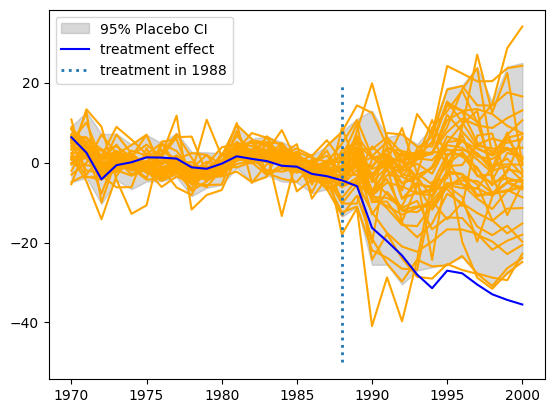

In [47]:
for treat in df[df.state!=3]['state'].unique():
    plt.plot(df[df.state==treat]['year'], placebo_effects[treat],color='orange')

plt.fill_between(df[df.state==3]['year'], lower_ci, upper_ci, color='gray',alpha=0.3, label='95% Placebo CI')
plt.plot(df[df.state==3]['year'], synthetic_control(3,model=Lasso(fit_intercept=False,max_iter=12000,tol=1e-3))[0], color='blue',label="treatment effect")    
plt.vlines(x=1988, ymin=-50, ymax=20, linestyle=":", lw=2, label="treatment in 1988")
plt.ylabel("")
plt.legend()

Placebo units with MSE at least 2 times higher than treated unit: [10, 13, 21, 22, 39]


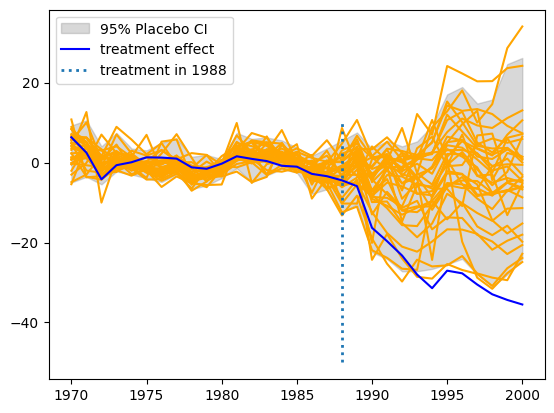

In [49]:
# remove control states with MSE at least 2 times higher than treated unit
threshold = 2 * synthetic_control(3, Lasso(fit_intercept=False,max_iter=12000,tol=1e-3))[1]
high_mse_units = [state for state, mse in placebo_mse.items() if mse >= threshold]
print("Placebo units with MSE at least 2 times higher than treated unit:", high_mse_units)

filtered_placebo_effects = {k: v for k, v in placebo_effects.items() if k not in high_mse_units}
placebo_array = np.array(list(filtered_placebo_effects.values())) 

alpha = 0.05
lower_ci = np.percentile(placebo_array, 100 * alpha / 2, axis=0)
upper_ci = np.percentile(placebo_array, 100 * (1 - alpha / 2), axis=0)

for treat in df[~df.state.isin(high_mse_units+[3])]['state'].unique():
    plt.plot(df[df.state==treat]['year'], placebo_effects[treat],color='orange')

plt.fill_between(df[df.state==3]['year'], lower_ci, upper_ci, color='gray',alpha=0.3, label='95% Placebo CI')
plt.plot(df[df.state==3]['year'], synthetic_control(3,Lasso(fit_intercept=False,max_iter=12000,tol=1e-3))[0], color='blue',label="treatment effect")    
plt.vlines(x=1988, ymin=-50, ymax=10, linestyle=":", lw=2, label="treatment in 1988")
plt.ylabel("")
plt.legend()